In [1]:
import os
import datetime

import numpy as np
import scipy
import fiona
import statistics
import math

import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, shape, mapping, Point, Polygon, MultiPolygon
from shapely.ops import cascaded_union

import matplotlib.pyplot as plt
from matplotlib import colors, cm, style
import matplotlib.patches as mpatches
from descartes import PolygonPatch

import osmnx as ox
import networkx as nx

In [2]:
from my_osm import get_osm_data
from my_isochrones import get_isochrones

In [3]:
style.use('seaborn-white')
output_folder = 'data'
osm_crs = 'EPSG:3857'

# Parameters

In [4]:
# Place                                Country              CRS
# Amsterdam | Rotterdam | The Hague    (The Netherlands)    EPSG:28992
# Madrid    | Barcelona | Valencia     (Spain)              EPSG:25830
# Stockholm | Goteborg  | Malmo        (Sweden)             EPSG:3006 ???

place_name = 'Utrecht'
local_crs = 'EPSG:28992'
place_extra = 0

In [5]:
trip_distances = [300, 500, 800]
trip_colors = ['#78c679', '#c2e699', '#ffffcc']
buffer = max(trip_distances)

# 1 hectare equals 10000 square meters
min_area = 5000
threshold = 0

tolerance = 10

# Load data

In [6]:
place = ox.geocode_to_gdf(place_name).to_crs(local_crs)
if place_extra:
    place['geometry'] = place.buffer(place_extra, join_style=2)

extent = place.buffer(buffer, join_style=2)
if len(extent) > 1:
    extent_shape = MultiPolygon([shape(part) for part in extent.to_crs('EPSG:4326')])     
else:
    extent_shape = extent.to_crs('EPSG:4326')[0]

<AxesSubplot:>

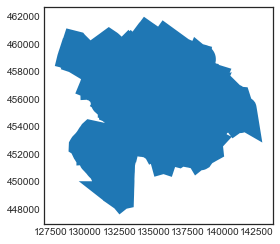

In [7]:
extent.plot()

In [8]:
g_leisure_tag_query = '["leisure"~"^(park|nature_reserve)"]'
greenery = get_osm_data(g_leisure_tag_query, extent, 'convexhull')

In [9]:
# excluding: allotments, flowerbed, farmland, farmyard, orchards, vineyard, plant_nursary (i.e. crop production, not for entering)
g_landuse_tag_query = '["landuse"~"^(forest|meadow|grass|village_green)"]'
greenery = greenery.append(get_osm_data(g_landuse_tag_query, extent, 'convexhull'))

In [10]:
g_natural_tag_query = '["natural"~"^(wood|scrub|heath|grassland|fell|shrubbery)"]'
greenery = greenery.append(get_osm_data(g_natural_tag_query, extent, 'convexhull'))

In [11]:
# custom filter: using the osmnx network_type 'walk' as a basis,
# but NOT excluding 'cycleways'.
# see https://github.com/gboeing/osmnx/blob/main/osmnx/downloader.py
# and https://github.com/gboeing/osmnx/issues/169
network_filter = (
        f'["highway"]["area"!~"yes"]["access"!~"private"]'
        f'["highway"!~"abandoned|bus_guideway|construction|motor|planned|platform|proposed|raceway"]'
        f'["foot"!~"no"]["service"!~"private"]'
    )

In [12]:
G = ox.graph_from_polygon(extent_shape, network_type='walk', custom_filter=network_filter, retain_all=True)
G = ox.project_graph(G, to_crs=local_crs)

In [13]:
all_paths = ox.utils_graph.graph_to_gdfs(ox.get_undirected(G), nodes=False, edges=True).to_crs(local_crs)

In [14]:
# highways of types with large amounts of traffic
# or with maximum speeds higher than 50
network_filter_unsafe_1 = (    
        f'["highway"~"motorway|trunk|primary|secondary|tertiary|motorway_link|trunk_link|primary_link|secondary_link|tertiary_link|bus_guideway|escape|raceway|busway"]'
    )
network_filter_unsafe_2 = (
        f'["maxspeed"~"50|60|70|80|90|100|110|120|130"]'
    )

In [15]:
G_unsafe_1 = ox.graph_from_polygon(extent_shape, network_type='walk', custom_filter=network_filter_unsafe_1, retain_all=True)
G_unsafe_1 = ox.project_graph(G_unsafe_1, to_crs=local_crs)

In [16]:
G_unsafe_2 = ox.graph_from_polygon(extent_shape, network_type='walk', custom_filter=network_filter_unsafe_2, retain_all=True)
G_unsafe_2 = ox.project_graph(G_unsafe_2, to_crs=local_crs)

In [17]:
paths_unsafe_1 = ox.utils_graph.graph_to_gdfs(ox.get_undirected(G_unsafe_1), nodes=False, edges=True).to_crs(local_crs)
paths_unsafe_2 = ox.utils_graph.graph_to_gdfs(ox.get_undirected(G_unsafe_2), nodes=False, edges=True).to_crs(local_crs)
paths_unsafe = pd.concat([paths_unsafe_1, paths_unsafe_2])
paths_unsafe.reset_index(drop=True, inplace=True)

In [18]:
def eliminate_intersections(G, G_other):
    
    G_self = G.copy()
    
    gdf_other = ox.utils_graph.graph_to_gdfs(ox.get_undirected(G_other), nodes=False, edges=True).to_crs(local_crs)
    other = gdf_other.geometry.unary_union
    
    to_drop = []

    for u, v, k, data in G_self.edges(data=True, keys=True):
        if data['geometry'].intersects(other):
            to_drop.append([u, v, k])
            
    for edge in to_drop:       
        G_self.remove_edge(edge[0], edge[1])
    
    G_self = ox.utils_graph.remove_isolated_nodes(G_self)
    
    return G_self

In [19]:
G_safe = eliminate_intersections(G, G_unsafe_1)
G_safe = eliminate_intersections(G_safe, G_unsafe_2)

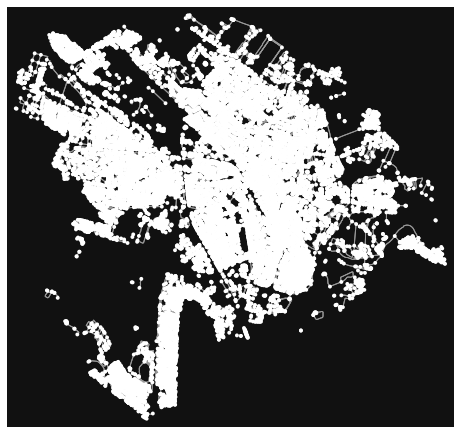

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [20]:
ox.plot_graph(G_safe)

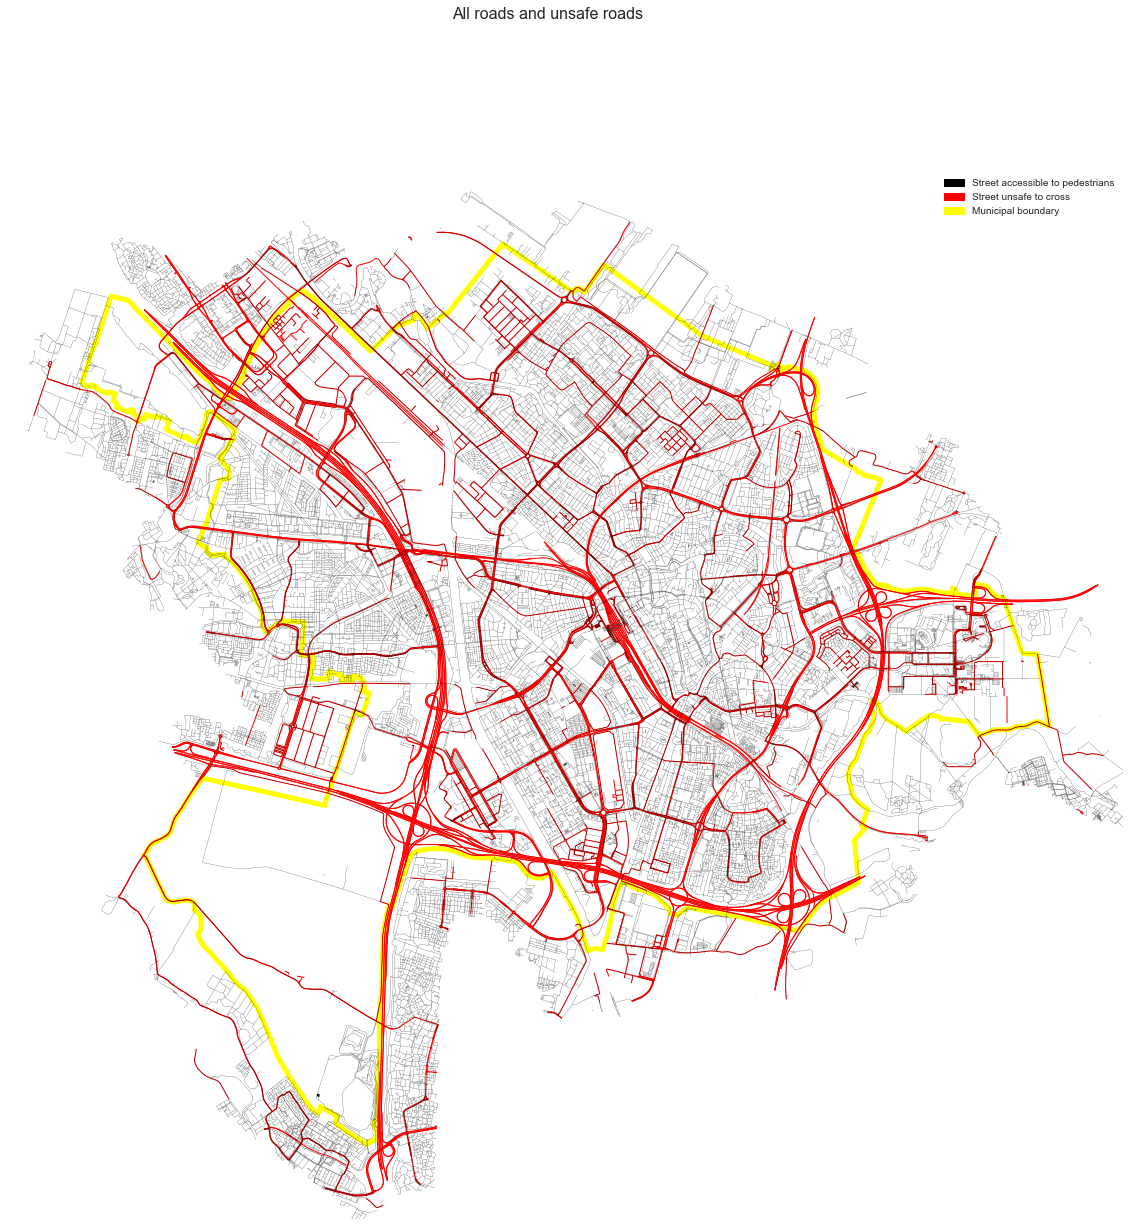

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20,20))
fig.suptitle('All roads and unsafe roads'.format(place_name, min_area), fontsize=16)

all_paths.plot(ax=axs, figsize=(12, 20), color='black', linewidth=0.2, zorder=6)
paths_unsafe.plot(ax=axs, color='red', linewidth=1, zorder=5)
place.plot(ax=axs, figsize=(12, 12), facecolor='none', edgecolor='yellow', linestyle='-', linewidth=5, zorder=1)

patch1 = mpatches.Patch(color='black', label='Street accessible to pedestrians')
patch2 = mpatches.Patch(color='red', label='Street unsafe to cross')
patch3 = mpatches.Patch(color='yellow', label='Municipal boundary')
handles = [patch1, patch2, patch3]
axs.legend(handles=handles)

bbox = place.total_bounds
margin = 1000
xlim = ([bbox[0]-margin, bbox[2]+margin])
ylim = ([bbox[1]-margin, bbox[3]+margin])
axs.set_xlim(xlim)
axs.set_ylim(ylim)
axs.axis('off')
    
plt.show()

# Simplify network graph

In [22]:
if tolerance > 0:
    G2 = ox.consolidate_intersections(G, rebuild_graph=True, tolerance=tolerance, dead_ends=True, reconnect_edges=True)
    print("After consolidating intersections with tolerance {}, {} out of {} nodes remain ({} %).".format(tolerance, len(G2), len(G), (round(100*len(G2)/len(G), 1))))
G = G2

After consolidating intersections with tolerance 10, 18805 out of 35976 nodes remain (52.3 %).


In [23]:
if tolerance > 0:
    paths = ox.utils_graph.graph_to_gdfs(ox.get_undirected(G2), nodes=False, edges=True).to_crs(local_crs)
else:
    paths = ox.utils_graph.graph_to_gdfs(ox.get_undirected(G), nodes=False, edges=True).to_crs(local_crs)
paths.reset_index(drop=True, inplace=True)

In [24]:
if tolerance > 0:
    nodes = ox.utils_graph.graph_to_gdfs(G2, nodes=True, edges=False).to_crs(local_crs)
else:
    nodes = ox.utils_graph.graph_to_gdfs(G, nodes=True, edges=False).to_crs(local_crs)
nodes.reset_index(drop=True, inplace=True)

In [25]:
nodes['_geom'] = nodes.geometry

In [26]:
if tolerance > 0:
    G2_safe = ox.consolidate_intersections(G_safe, rebuild_graph=True, tolerance=tolerance, dead_ends=True, reconnect_edges=True)
    print("After consolidating intersections with tolerance {}, {} out of {} nodes remain ({} %).".format(tolerance, len(G2_safe), len(G_safe), (round(100*len(G2_safe)/len(G_safe), 1))))
G_safe = G2_safe

After consolidating intersections with tolerance 10, 17524 out of 30712 nodes remain (57.1 %).


In [27]:
if tolerance > 0:
    paths_safe = ox.utils_graph.graph_to_gdfs(ox.get_undirected(G2_safe), nodes=False, edges=True).to_crs(local_crs)
else:
    paths_safe = ox.utils_graph.graph_to_gdfs(ox.get_undirected(G_safe), nodes=False, edges=True).to_crs(local_crs)
paths_safe.reset_index(drop=True, inplace=True)

In [28]:
if tolerance > 0:
    nodes_safe = ox.utils_graph.graph_to_gdfs(G2_safe, nodes=True, edges=False).to_crs(local_crs)
else:
    nodes_safe = ox.utils_graph.graph_to_gdfs(G_safe, nodes=True, edges=False).to_crs(local_crs)
nodes_safe.reset_index(drop=True, inplace=True)

In [29]:
nodes_safe['_geom'] = nodes_safe.geometry

# Filter greenspaces

In [30]:
def greenspace_filter(gdf, local_crs,
                      threshold=0, place=None, min_area=10000, G=None):
    """
    gdf = geoseries of greenery polygons (e.g. greenery.geometry)
    return = a union of filtered polygons
    [optional] threshold to merge spaces in proximity (in meters)
    [optional] place geoseries of total area geometries (e.g. place_gdf.geometry)
    [optional] minimum area for greenspace filter, default value set
    [optional] graph which greenspace should intersect nodes and edges of
    """
    
    filtered = gdf.copy()
    
    # only polygons, no points or lines
    filtered = filtered[(filtered.geom_type == 'Polygon')|(filtered.geom_type == 'MultiPolygon')]
    
    #union of adjacent and overlapping polygons
    filtered['geometry'] = filtered.buffer(threshold)
    filtered = gpd.GeoDataFrame(filtered.unary_union).rename(columns={0:'geometry'}).set_geometry('geometry').set_crs(local_crs)
    filtered['geometry'] = filtered.buffer(-threshold)

    # filter on intersect with place
    if place is not None:
        filtered = gpd.sjoin(filtered, gpd.GeoDataFrame(place.geometry), how="left", predicate='within')
        filtered = filtered[filtered.index_right.notnull()].drop(columns=['index_right'])
        
    # filter on minimum area
    if min_area > 0:
        filtered = filtered[filtered.geometry.area>=min_area]
    
    # filter on intersection with network
    if G:
        edges = ox.utils_graph.graph_to_gdfs(G, nodes=False, edges=True)
        filtered = gpd.sjoin(filtered, gpd.GeoDataFrame(edges.reset_index(drop=True).geometry), how="left", predicate='intersects')
        filtered = filtered[filtered.index_right.notnull()].drop(columns=['index_right'])
        
        filtered.drop_duplicates(inplace=True)
        
        nodes = ox.utils_graph.graph_to_gdfs(G, nodes=True, edges=False)
        filtered = gpd.sjoin(filtered, gpd.GeoDataFrame(nodes.reset_index(drop=True).geometry), how="left", predicate='intersects')
        filtered = filtered[filtered.index_right.notnull()].drop(columns=['index_right'])

    filtered.drop_duplicates(inplace=True)
    return filtered

In [31]:
greenspaces_filtered = greenspace_filter(greenery, local_crs, threshold=threshold, place=None, min_area=min_area, G=G)
'{} greenspaces fulfil the criteria for filtering'.format(len(greenspaces_filtered))

'287 greenspaces fulfil the criteria for filtering'

In [32]:
greenspaces_safe_filtered = greenspaces_filtered.copy()

## Isochrones

In [33]:
get_isochrones(G, greenspaces_filtered, trip_distances, local_crs)

In [34]:
get_isochrones(G_safe, greenspaces_safe_filtered, trip_distances, local_crs)

In [35]:
trip_labels = []
for trip_distance in trip_distances:
    trip_labels.append('Within {}m walk'.format(trip_distance))

In [36]:
trip_labels_safe = []
for trip_distance in trip_distances:
    trip_labels_safe.append('Within a safe {}m walk'.format(trip_distance))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


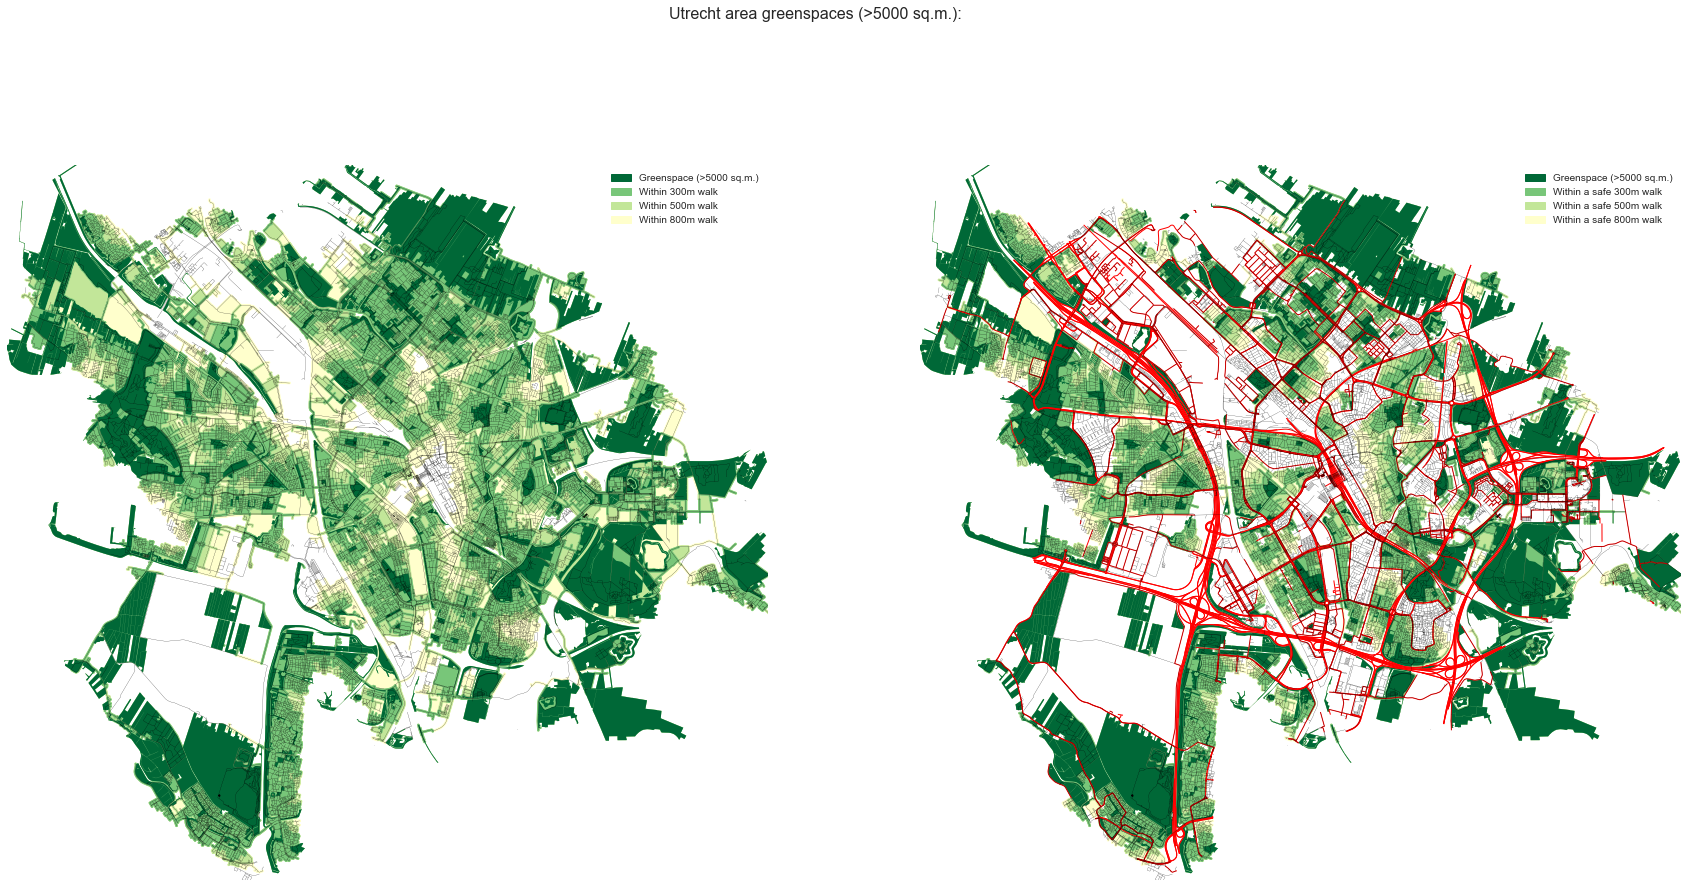

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30,15))
fig.suptitle('{0} area greenspaces (>{1} sq.m.): '.format(place_name, min_area), fontsize=16)

for i in range(len(trip_distances)):
    greenspaces_filtered.set_geometry(('geom_iso_'+str(trip_distances[i]))).plot(ax=axs[0], color=trip_colors[i], zorder=len(trip_distances)-i)
greenspaces_filtered.plot(ax=axs[0], figsize=(12, 20), color='#006837', zorder=4)
all_paths.plot(ax=axs[0], figsize=(12, 20), color='black', linewidth=0.2, zorder=5)
# place.plot(ax=axs[0], figsize=(12, 12), facecolor='none', edgecolor='#dd1c77', linestyle='-', linewidth=5, zorder=6)

for i in range(len(trip_distances)):
    greenspaces_safe_filtered.set_geometry(('geom_iso_'+str(trip_distances[i]))).plot(ax=axs[1], color=trip_colors[i], zorder=len(trip_distances)-i)
greenspaces_safe_filtered.plot(ax=axs[1], figsize=(12, 20), color='#006837', zorder=4)
all_paths.plot(ax=axs[1], figsize=(12, 20), color='black', linewidth=0.2, zorder=6)
paths_unsafe.plot(ax=axs[1], color='red', linewidth=1, zorder=5)

gs = mpatches.Patch(color='#006837', label='Greenspace (>{} sq.m.)'.format(min_area))
handles = [gs]
handles_safe = [gs]
for i in range(len(trip_distances)):
    handles.append(mpatches.Patch(color=trip_colors[i], label=trip_labels[i]))
    handles_safe.append(mpatches.Patch(color=trip_colors[i], label=trip_labels_safe[i]))
for ax in axs:
    ax.legend(loc='upper right')
axs[0].legend(handles=handles)
axs[1].legend(handles=handles_safe)

bbox = place.total_bounds
margin = 1000
xlim = ([bbox[0]-margin, bbox[2]+margin])
ylim = ([bbox[1]-margin, bbox[3]+margin])
for ax in axs:
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.axis('off')
    

plt.show()